### Plot llc90 MITgcm mds output using ECCOv4-py and cartopy

November 2018

Elena Gerwing

In [1]:
import numpy as np
import numpy.ma as ma
from matplotlib import pyplot as plt
from matplotlib import cm,colors,colorbar

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 8

In [2]:
import cartopy.crs as ccrs
import cmocean.cm as cmo
import cartopy.feature as cfeature

In [3]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

matplotlib: 3.0.1


In [4]:
import cartopy
print('cartopy: {}'.format(cartopy.__version__))

cartopy: 0.17.0


In [5]:
import pyresample as pr

In [6]:
import xarray as xr
import xgcm
import xmitgcm

In [7]:
import pprint

In [8]:
import os
# Background images downloaded from: https://neo.sci.gsfc.nasa.gov/
# I downloaded Blue Marble and a Topography
os.environ["CARTOPY_USER_BACKGROUNDS"] = "./backgrounds/"

In [9]:
data_dir = './data/'
grid_dir = './grid/'

In [10]:
ds = xmitgcm.open_mdsdataset(data_dir, grid_dir, geometry='llc',
                             prefix=['Eta'],
                             iters='all',
                             delta_t=3600,
                             ref_date='1979-01-01 00:00:00',
                             swap_dims = False,
                             llc_method = 'smallchunks')
ds

/Users/egerwing/.miniconda3/lib/python3.6/site-packages/xmitgcm/mds_store.py:735: UserWarning: Couldn't find available_diagnostics.log in ./data/. Using default version.
  "in %s. Using default version." % data_dir)
/Users/egerwing/.miniconda3/lib/python3.6/site-packages/xmitgcm/utils.py:336: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/Users/egerwing/.miniconda3/lib/python3.6/site-packages/xmitgcm/mds_store.py:735: UserWarning: Couldn't find available_diagnostics.log in ./data/. Using default version.
  "in %s. Using default version." % data_dir)
/Users/egerwing/.miniconda3/lib/python3.6/site-packages/xmitgcm/utils.py:336: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/Users/egerwing/.miniconda3/lib/python3.6/site-packages/xmitgcm/mds_store.py:735: UserWarning: Couldn't find available_diagnostics.log in ./data/. Using default version.
  "in %s. Using default versio

<xarray.Dataset>
Dimensions:  (face: 13, i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 2)
Coordinates:
  * i        (i) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * j        (j) int64 0 1 2 3 4 5 6 7 8 9 10 ... 80 81 82 83 84 85 86 87 88 89
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
  * k        (k) int64 0 1 2 3 4 5 6 7 8 9 10 ... 40 41 42 43 44 45 46 47 48 49
  * k_u      (k_u) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_l      (k_l) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * k_p1     (k_p1) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49 50
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, j, i) >f4 dask.array<shape=(13, 90, 90), chunksize=(1, 90, 90)>
    YC       (face, j, i) >f4 dask.array<shape=(13, 90, 90), chunksize=(1, 90, 90)>
    XG     

In [11]:
def plot_tiles_proj_carto(lons, lats, data, 
                    user_lat_0 = 45, 
                    projection_type = 'robin', 
                    plot_type = 'pcolor', 
                    user_lon_0 = 0,
                    user_width = 5000000,
                    user_height = 4500000,
                    background_type = 'fc', 
                    show_cbar_label = False, 
                    show_colorbar = False, 
                    cbar_label = '',
                    bound_lat = 50, 
                    num_levels = 20, 
                    cmap='viridis', 
                    map_resolution='c',
                    dx=.25, 
                    dy=.25,
                    show_grid_lines = True,
                    **kwargs):
    
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
    # default projection type
    # by default the left most longitude in the global map is -180E.
    # by default do not show a colorbar 
    # by default the colorbar has no label
    # by default take the min and max of the values
    cmin = np.nanmin(data)
    cmax = np.nanmax(data)
    
    # by default the plot_type is pcolor.
    # the default number of levels for contourf, 
    # default background is to fill continents with gray color
    # default bounding lat for polar stereographic projection is 50 N
    
    
    #%%
    for key in kwargs:
        if key == "cmin":
            cmin = kwargs[key]
        elif key == "cmax":
            cmax =  kwargs[key]
        else:
            print ("unrecognized argument ", key)     

    #%%
    if type(lons) == xr.core.dataarray.DataArray:
        lons_1d = lons.values.reshape(np.product(lons.values.shape))
        lats_1d = lats.values.reshape(np.product(lats.values.shape))   

    elif type(lons) == np.ndarray:
        lons_1d = lons.reshape(np.product(lons.shape))
        lats_1d = lats.reshape(np.product(lats.shape) )       
    else:
        print ('lons and lats variable either a DataArray or numpy.ndarray')
        print ('lons found type ', type(lons))
        print ('lats found type ', type(lats))        
        return
    
    if type(data) == xr.core.dataarray.DataArray:
        data = data.values


    elif type(data) != np.ndarray and type(data) != np.ma.core.MaskedArray:
        print ('data must be either a DataArray or ndarray type \n')
        print ('found type ', type(data))
        return    
    

    print ('projection type ', projection_type)
    
    f = plt.figure(figsize=(12,9),dpi=90)
    if projection_type == 'plate':
        ax = f.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=user_lon_0))
        ax.set_global()
    elif projection_type == 'robin':    
        ax = f.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=user_lon_0))
        ax.set_global()
    elif projection_type == 'ortho':
        ax = f.add_subplot(1, 1, 1, projection=ccrs.Orthographic(central_longitude=user_lon_0, 
                                                                 central_latitude=user_lat_0, globe=None))
        ax.set_global()

    elif projection_type == 'mollweide':
        ax = f.add_subplot(1, 1, 1, projection=ccrs.Mollweide(central_longitude=user_lon_0, globe=None))
        ax.set_global()
                           
    elif projection_type == 'stereo':    
        if bound_lat > 0:
            ax = f.add_subplot(1, 1, 1, projection=ccrs.NorthPolarStereo(central_longitude=user_lon_0))
            ax.set_extent([-180.0, 180.0, bound_lat, 90.0], crs=ccrs.PlateCarree())
        else:
            ax = f.add_subplot(1, 1, 1, projection=ccrs.SouthPolarStereo(central_longitude=user_lon_0))
            ax.set_extent([-180.0, 180.0, bound_lat, -90.0], crs=ccrs.PlateCarree())
    else:
        raise ValueError('projection type must be either "plate", "robin", "ortho", "mollweide" or "stereo"')
        print ('found ', projection_type)
    
    
    
    f.canvas.draw()
    #%%
    # get a reference to the current figure (or make a figure if none exists)
    if background_type == 'fc':
        ax.add_feature(cfeature.LAND, facecolor='peru', zorder=0)
    elif background_type == 'bm':
        ax.background_img(name='BM_jun', resolution='high')
    elif background_type == 'topo':
        ax.background_img(name='topo_grey', resolution='high')
    elif background_type == 'stock':
        ax.stock_img()

    ax.coastlines(resolution='110m') # also possible: 50, 10,..
    
    # prepare for the interpolation or nearest neighbor mapping
    
    # first define the lat lon points of the original data
    orig_grid = pr.geometry.SwathDefinition(lons=lons_1d, lats=lats_1d)
    
    # the latitudes to which we will interpolate
    lat_tmp = np.linspace(-89.5, 89.5, 90/dy)
    lat_tmp = np.arange(-90.0, 90.0+dy, dy)
    lon_tmp = np.arange(-180.0,180.0+dx,dx)
   
    new_grid_lon, new_grid_lat = np.meshgrid(lon_tmp, lat_tmp)
  
    # define the lat lon points 
    new_grid  = pr.geometry.GridDefinition(lons=new_grid_lon, 
                                               lats=new_grid_lat)
        
    
    data_latlon_projection = \
            pr.kd_tree.resample_nearest(orig_grid, data, new_grid, 
                                        radius_of_influence=100000, 
                                        fill_value=None) 

    if plot_type == 'pcolor':
            # plot using pcolor 
        im=ax.pcolormesh(new_grid_lon, new_grid_lat, data_latlon_projection, 
                        vmin=cmin, vmax=cmax, transform=ccrs.PlateCarree(), cmap=cmap)

    elif plot_type == 'contourf':
            # create a set of contours spanning from cmin to cmax over
            # num_levels intervals
        contour_levels = np.linspace(cmin, cmax, num_levels)
            
            # plot using contourf
        im=ax.contourf(new_grid_lon, new_grid_lat, data_latlon_projection, vmin=cmin, vmax=cmax, 
                    transform=ccrs.PlateCarree(), cmap=cmap,
                    levels=contour_levels,
                       extend='both')
    else:
        print ('plot type must be either "pcolor" or "contourf"  ')
        print ('found type ', plot_type)
            #return
    
    # grid labels only available for PlateCarree and Mercator projection 
    if projection_type == 'plate' and show_grid_lines == True:      
        ax.gridlines(draw_labels=True,color='dimgray', linestyle='--', zorder=3)    
    elif show_grid_lines == True:
        ax.gridlines(draw_labels=False,color='dimgray', linestyle='--', zorder=3)   
 
    if show_colorbar:
        f.subplots_adjust(right=0.8)
        #[left, bottom, width, height]
        h=.6;w=.025
        cbar_ax = f.add_axes([0.85, (1-h)/2, w, h])
        cbar = f.colorbar(im, extend='both', cax=cbar_ax)#, format='%.0e')          

        if show_cbar_label:
            cbar.set_label(cbar_label)
    # set the current axes to be the map, not the colorbar
    plt.sca(ax)

    # return a reference to the figure and the map axes
    return f, ax, im
    #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [12]:
timestep = 1

In [13]:
eta = ds.ETAN.isel(time=timestep)
eta_masked =  ma.masked_where(ds.hFacC[0,:,:,:] == 0,eta)

### PlateCarree projection, pcolormesh

projection type  plate


/Users/egerwing/.miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


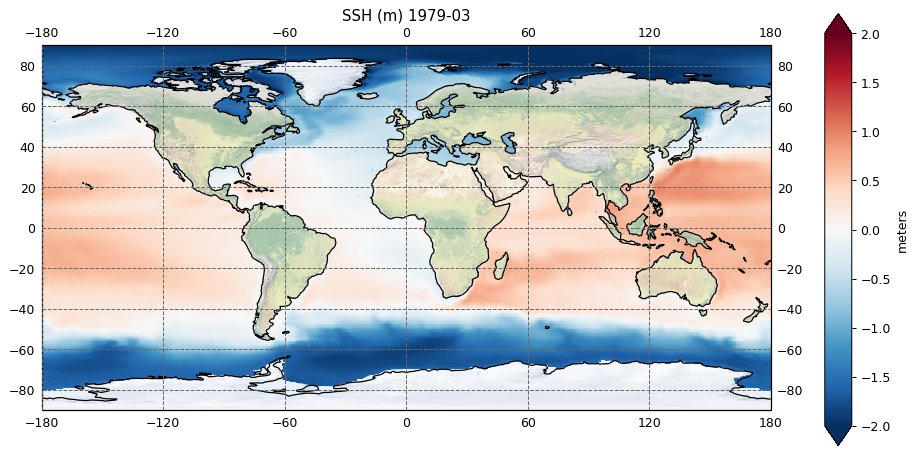

In [14]:
f,ax,im=plot_tiles_proj_carto(ds.XC,
                       ds.YC,
                       eta_masked,
                       show_colorbar=True,
                       cmap='RdBu_r',
                        cmin = -2.0,
                        cmax = 2.0,
                       show_grid_lines = True,
                       background_type = 'stock',
                       user_lon_0=0.0, 
                       projection_type = 'plate',
                       show_cbar_label = True,cbar_label='meters')
f.set_figheight(8)
f.set_figwidth(12)
plt.title('SSH (m) ' + str(ds.time[timestep].values)[0:7],pad=20);

### PlateCarree projection, contourf

projection type  plate


/Users/egerwing/.miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


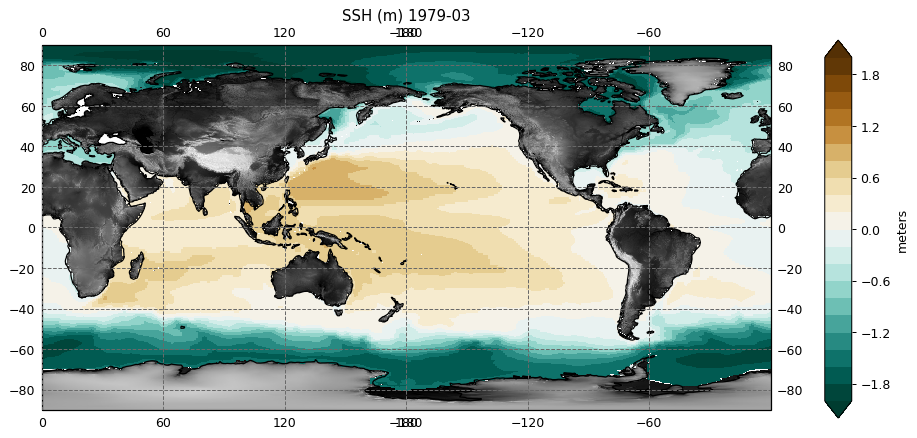

In [15]:
my_cmin =-2.; my_cmax=2.;  my_cint=.2
my_num_levels = len(np.arange(my_cmin,my_cmax+my_cint, my_cint))

f,ax,im=plot_tiles_proj_carto(ds.XC,
                       ds.YC,
                       eta_masked,
                       show_colorbar=True,
                        cmap='BrBG_r',
                       num_levels = my_num_levels,
                       cmin = my_cmin,
                       cmax = my_cmax,
                       plot_type = 'contourf',
                       show_grid_lines = True,
                       background_type = 'topo',
                       user_lon_0=180.0, 
                       projection_type = 'plate',
                       show_cbar_label = True,cbar_label='meters')
f.set_size_inches(w=12,h=7)
plt.title('SSH (m) ' + str(ds.time[timestep].values)[0:7],pad=20);

### PlateCarree projection, contourf

projection type  ortho


/Users/egerwing/.miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/egerwing/.miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


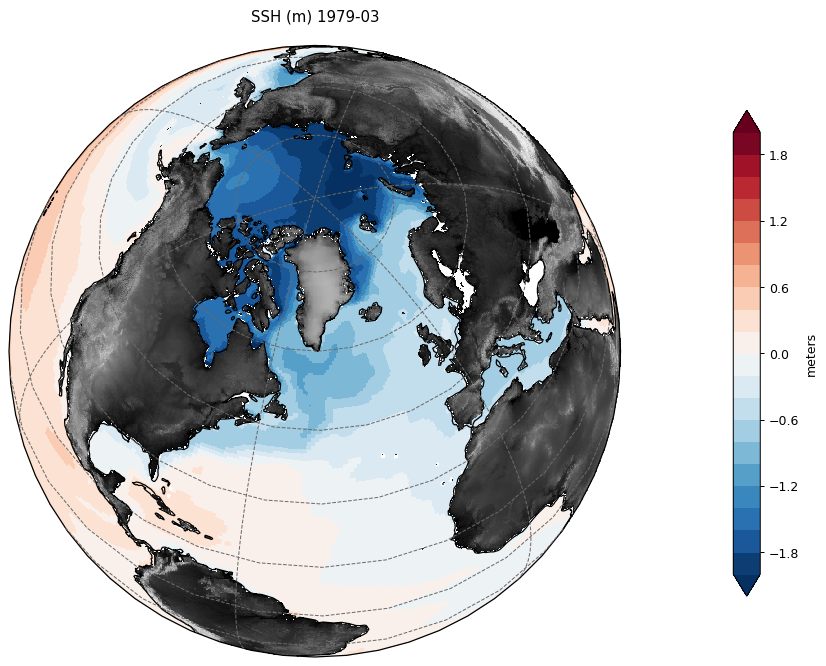

In [16]:
my_cmin =-2.; my_cmax=2.;  my_cint=.2
my_num_levels = len(np.arange(my_cmin,my_cmax+my_cint, my_cint))

f=plot_tiles_proj_carto(ds.XC,
                       ds.YC,
                       eta_masked,
                       show_colorbar=True,
                       cmap='RdBu_r',
                       num_levels = my_num_levels,
                       cmin = my_cmin,
                       cmax = my_cmax,
                       plot_type = 'contourf',
                       show_grid_lines = True,
                       background_type = 'topo',
                       user_lon_0=-45.0, 
                        user_lat_0 = 60.0,
                       projection_type = 'ortho',
                       show_cbar_label = True,cbar_label='meters')
plt.title('SSH (m) ' + str(ds.time[timestep].values)[0:7],pad=20);

### North Polar Stereographic projection, pcolormesh

projection type  stereo


/Users/egerwing/.miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


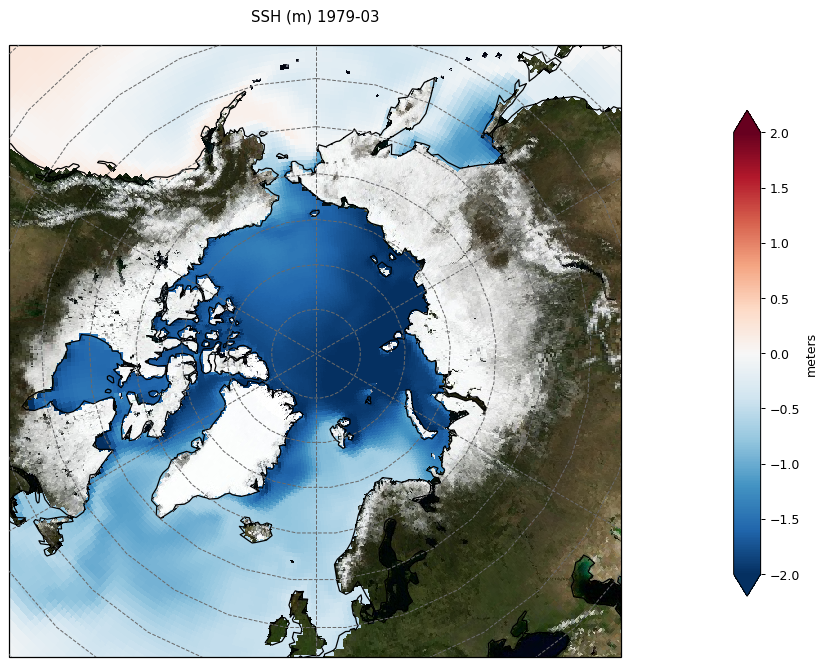

In [17]:
f=plot_tiles_proj_carto(ds.XC,
                       ds.YC,
                       eta_masked,
                       show_colorbar=True,
                        cmap='RdBu_r',
                       cmin = -2.0,
                       cmax = 2.0,
                       show_grid_lines = True,
                       background_type = 'bm',
                       user_lon_0=0.0, 
                       projection_type = 'stereo',
                       show_cbar_label = True,cbar_label='meters')
plt.title('SSH (m) ' + str(ds.time[timestep].values)[0:7],pad=20);

### South Polar Stereographic projection, contourf

projection type  stereo


/Users/egerwing/.miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


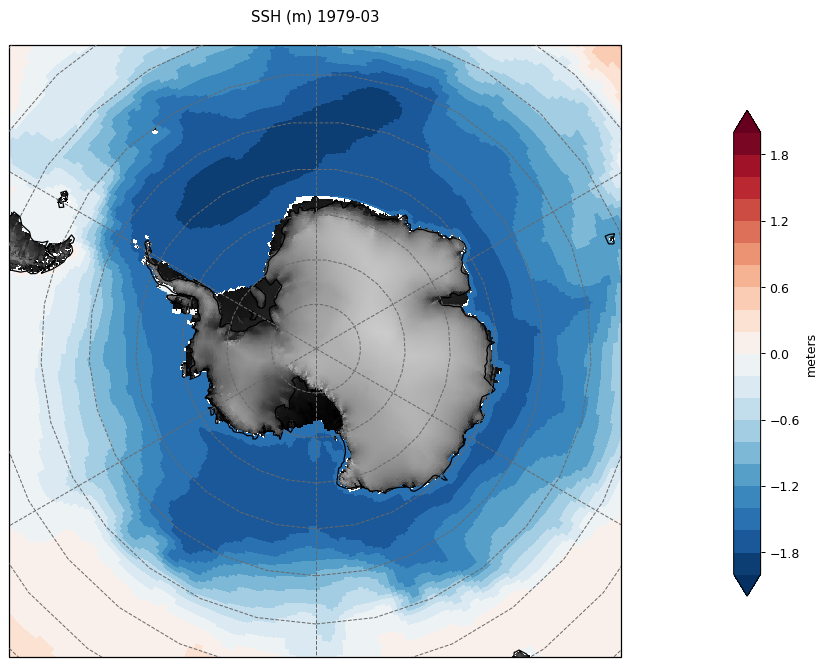

In [18]:
my_cmin =-2.; my_cmax=2.;  my_cint=.2
my_num_levels = len(np.arange(my_cmin,my_cmax+my_cint, my_cint))

f=plot_tiles_proj_carto(ds.XC,
                       ds.YC,
                       eta_masked,
                       show_colorbar=True,
                       cmap='RdBu_r',
                       num_levels = my_num_levels,
                       cmin = my_cmin,
                       cmax = my_cmax,
                       plot_type = 'contourf',
                       show_grid_lines = True,
                       background_type = 'topo',
                        bound_lat = -50.0,
                       projection_type = 'stereo',
                       show_cbar_label = True,cbar_label='meters')
plt.title('SSH (m) ' + str(ds.time[timestep].values)[0:7],pad=20);

### Robinson projection, contourf

projection type  robin


/Users/egerwing/.miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


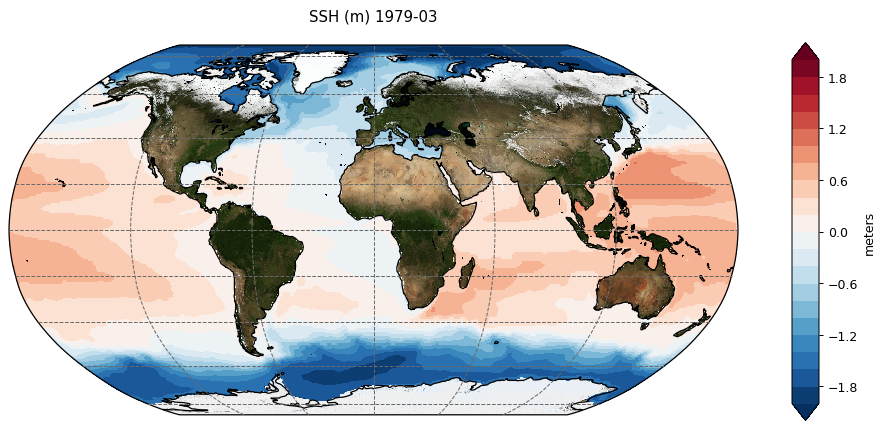

In [19]:
my_cmin =-2.; my_cmax=2.;  my_cint=.2
my_num_levels = len(np.arange(my_cmin,my_cmax+my_cint, my_cint))

f,ax,im=plot_tiles_proj_carto(ds.XC,
                       ds.YC,
                       eta_masked,
                       show_colorbar=True,
                       cmap='RdBu_r',
                       num_levels = my_num_levels,
                       cmin = my_cmin,
                       cmax = my_cmax,
                       plot_type = 'contourf',
                       show_grid_lines = True,
                       background_type = 'bm',
                       user_lon_0=0.0, 
                       projection_type = 'robin',
                       show_cbar_label = True,cbar_label='meters')
f.set_size_inches(w=12,h=7)
plt.title('SSH (m) ' + str(ds.time[timestep].values)[0:7],pad=20);

### Mollweide, pcolormesh

projection type  mollweide


/Users/egerwing/.miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


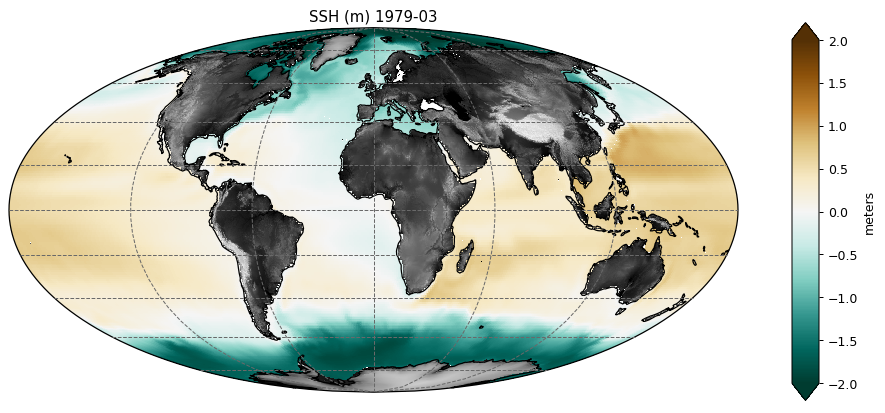

In [20]:
f,ax,im=plot_tiles_proj_carto(ds.XC,
                       ds.YC,
                       eta_masked,
                       show_colorbar=True,
                       cmap='BrBG_r',
                        cmin = -2.0,
                        cmax = 2.0,
                       show_grid_lines = True,
                       background_type = 'topo',
                       user_lon_0=0.0, 
                       projection_type = 'mollweide',
                       show_cbar_label = True,cbar_label='meters')
f.set_size_inches(w=12,h=7)
plt.title('SSH (m) ' + str(ds.time[timestep].values)[0:7]);

### Robinson projection, pcolormesh

projection type  robin


/Users/egerwing/.miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


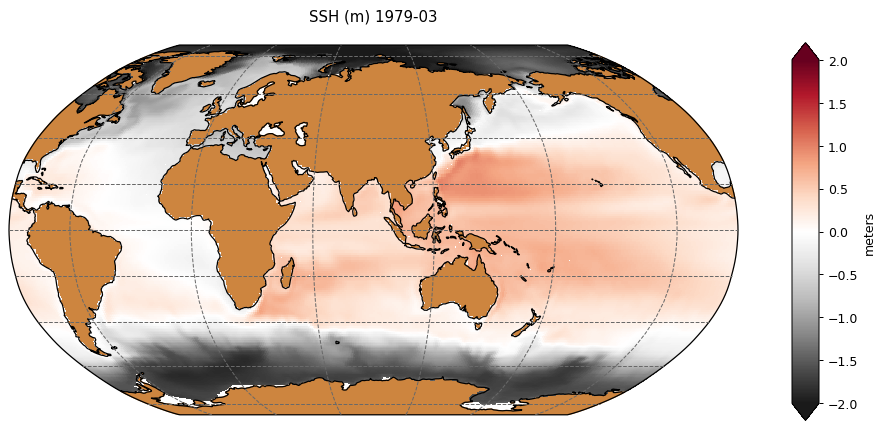

In [21]:
f,ax,im=plot_tiles_proj_carto(ds.XC,
                       ds.YC,
                       eta_masked,
                       show_colorbar=True,
                       cmap='RdGy_r',
                        cmin = -2.0,
                        cmax = 2.0,
                       show_grid_lines = True,
                       background_type = 'fc',
                       user_lon_0=90.0, 
                       projection_type = 'robin',
                       show_cbar_label = True,cbar_label='meters')
f.set_size_inches(w=12,h=7)
plt.title('SSH (m) ' + str(ds.time[timestep].values)[0:7],pad=20);

### Mollweide, contourf

projection type  mollweide


/Users/egerwing/.miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


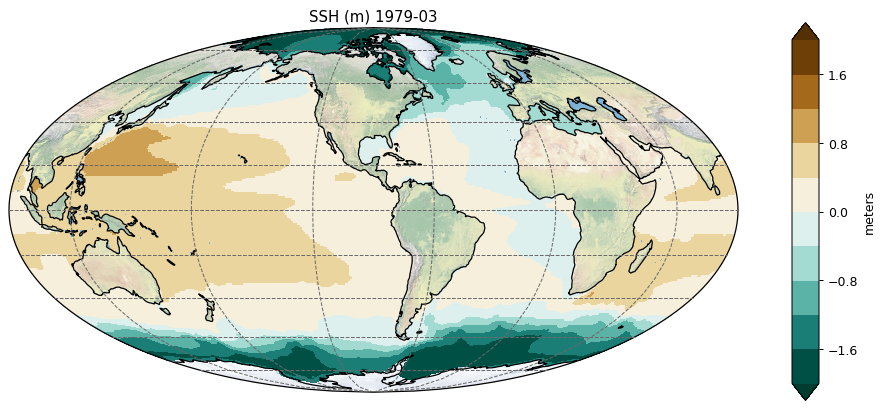

In [22]:
my_cmin =-2.; my_cmax=2.;  my_cint=.4
my_num_levels = len(np.arange(my_cmin,my_cmax+my_cint, my_cint))

f,ax,im=plot_tiles_proj_carto(ds.XC,
                       ds.YC,
                       eta_masked,
                       show_colorbar=True,
                       cmap='BrBG_r',
                       num_levels = my_num_levels,
                       cmin = my_cmin,
                       cmax = my_cmax,
                       plot_type = 'contourf',
                       show_grid_lines = True,
                       background_type = 'stock',
                       user_lon_0=-90.0, 
                       projection_type = 'mollweide',
                       show_cbar_label = True,cbar_label='meters')
f.set_size_inches(w=12,h=7)
plt.title('SSH (m) ' + str(ds.time[timestep].values)[0:7]);

### Orthographic projection, pcolormesh

projection type  ortho


/Users/egerwing/.miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


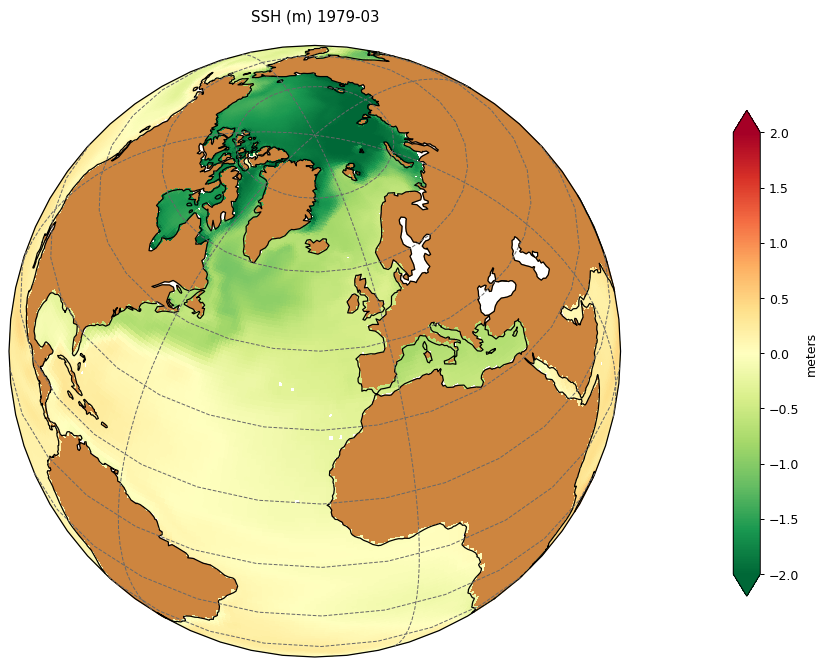

In [23]:
f=plot_tiles_proj_carto(ds.XC,
                       ds.YC,
                       eta_masked,
                       show_colorbar=True,
                        cmap='RdYlGn_r',
                       cmin = -2.0,
                       cmax = 2.0,
                       show_grid_lines = True,
                       background_type = 'fc',
                       user_lon_0=-20.0, 
                       projection_type = 'ortho',
                       show_cbar_label = True,cbar_label='meters')
plt.title('SSH (m) ' + str(ds.time[timestep].values)[0:7],pad=20);

### North Polar Stereographic projection, pcolormesh

projection type  stereo


/Users/egerwing/.miniconda3/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:704: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  self.set_xlim([x1, x2])
/Users/egerwing/.miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:120: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


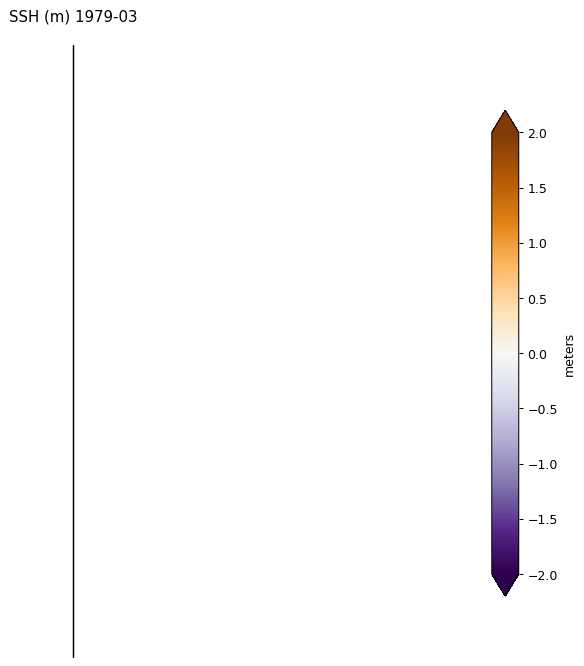

In [24]:
my_cmin =-2.; my_cmax=2.;  my_cint=.4
my_num_levels = len(np.arange(my_cmin,my_cmax+my_cint, my_cint))

f=plot_tiles_proj_carto(ds.XC,
                       ds.YC,
                       eta_masked,
                       show_colorbar=True,
                        cmap='PuOr_r',
                       num_levels = my_num_levels,
                       cmin = my_cmin,
                       cmax = my_cmax,
 #                      plot_type = 'contourf',
                       show_grid_lines = True,
                       background_type = 'fc',
                       user_lon_0=180.0, 
                       projection_type = 'stereo',
                       show_cbar_label = True,cbar_label='meters')
plt.title('SSH (m) ' + str(ds.time[timestep].values)[0:7],pad=20);